# Loading libraries



In [61]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator
#import seaborn as sns
#from datetime import datetime
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.seasonal import seasonal_decompose
#import plotly.express as px
#from sktime.forecasting.model_selection import temporal_train_test_split #train/test split for TS
#from sktime.forecasting.base import ForecastingHorizon
#from sktime.utils.plotting import plot_series, plot_correlations
#from sktime.forecasting.arima import AutoARIMA
#from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
#%matplotlib inline

https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey

In [62]:
# The option "parse_dates" casts any column containing dates to pd.to_datetime(). We need to provide the column containing a date
data = pd.read_csv("/content/drive/MyDrive/Ironhack1/Week_9/DatasetFiles/menthal_health_in_tech.csv",parse_dates=['Timestamp'])
#parse_date tells the column 'Timestamp' that its datetime dtype
data.head(20)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22,33,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,...,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN
6,2014-08-27 11:31:50,35,Female,United States,MI,NaN,Yes,Yes,Sometimes,1-5,...,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No,NaN
7,2014-08-27 11:32:05,39,M,Canada,NaN,NaN,No,No,Never,1-5,...,Don't know,No,No,No,No,No,No,No,No,NaN
8,2014-08-27 11:32:39,42,Female,United States,IL,NaN,Yes,Yes,Sometimes,100-500,...,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
9,2014-08-27 11:32:43,23,Male,Canada,NaN,NaN,No,No,Never,26-100,...,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No,NaN


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
data.shape

(1259, 27)

In [65]:
data.info()
#all object except Age

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  1259 non-null   datetime64[ns]
 1   Age                        1259 non-null   int64         
 2   Gender                     1259 non-null   object        
 3   Country                    1259 non-null   object        
 4   state                      744 non-null    object        
 5   self_employed              1241 non-null   object        
 6   family_history             1259 non-null   object        
 7   treatment                  1259 non-null   object        
 8   work_interfere             995 non-null    object        
 9   no_employees               1259 non-null   object        
 10  remote_work                1259 non-null   object        
 11  tech_company               1259 non-null   object        
 12  benefi

DATA PREPARATION/CLEANING

In [66]:
#converting all the column names into lower case
data.columns = data.columns.str.lower()

In [67]:
#checking to see for salient values like NaN and missing, etc.
data.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,1259,1.259000e+03,1259,1259,744,1241,1259,1259,995,1259,...,1259,1259,1259,1259,1259,1259,1259,1259,1259,164
unique,1246,NaN,49,48,45,2,2,2,4,6,...,5,3,3,3,3,3,3,3,2,160
top,2014-08-27 12:44:51,NaN,Male,United States,CA,No,No,Yes,Sometimes,6-25,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,NaN,615,751,138,1095,767,637,465,290,...,563,490,925,774,516,1008,557,576,1075,5
first,2014-08-27 11:29:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-02-01 23:04:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.942815e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.818299e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-1.726000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.700000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
data.isnull().sum()

timestamp                       0
age                             0
gender                          0
country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

age is looking like it needs work, and there are a bunch of missing values. Also, I can drop certain columns like timestamp and comment as they carry no importance in my treatment prediciton. More on that in the next cell.
Additionally, 'work_interference' will need to be looked in to.

In [69]:
data['country'].value_counts()
#this is misleading. Most participants are from the US. This might lead to a conclusion that most people in need of treatment are from the US. 

United States             751
United Kingdom            185
Canada                     72
Germany                    45
Ireland                    27
Netherlands                27
Australia                  21
France                     13
India                      10
New Zealand                 8
Poland                      7
Switzerland                 7
Sweden                      7
Italy                       7
South Africa                6
Belgium                     6
Brazil                      6
Israel                      5
Singapore                   4
Bulgaria                    4
Austria                     3
Finland                     3
Mexico                      3
Russia                      3
Denmark                     2
Greece                      2
Colombia                    2
Croatia                     2
Portugal                    2
Moldova                     1
Georgia                     1
Bahamas, The                1
China                       1
Thailand  

I will drop the 'country' column, and the 'state' one as well. They have no bearing for my analysis.

In [70]:
data = data.drop(['country','state','timestamp','comments'], axis = 1)

In [71]:
#checking the entry types for gender, commonly a source for required cleaning
data['gender'].value_counts().reset_index()

,index,gender
0,Male,615
1,male,206
2,Female,121
3,M,116
4,female,62
5,F,38
6,m,34
7,f,15
8,Make,4
9,Male,3


As expected, the gender column is a mess. Must be corrected. I will create a third gender-type called 'Other' for all those who did not answer and do not identify as Male or Female.

In [72]:
data['gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)

data['gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

data["gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Other', inplace = True)

In [73]:
#checking to see the new output
data['gender'].value_counts().reset_index()

,index,gender
0,Male,991
1,Female,247
2,Other,21


There is a clear imbalance of genders. Most participants of the survey are male. However, this does not suggest in any way that most people with mental health issues are male. For all we know, this could imply that most employees in the tech industry are male. We just don't know from this dataset alone.

In [74]:
#let us see what we can do in order to correct the 'age' column.
data['age'].value_counts()

 29             85
 32             82
 26             75
 27             71
 33             70
 28             68
 31             67
 34             65
 30             63
 25             61
 35             55
 23             51
 24             46
 37             43
 38             39
 36             37
 40             33
 39             33
 43             28
 22             21
 41             21
 42             20
 21             16
 45             12
 46             12
 44             11
 19              9
 18              7
 48              6
 50              6
 20              6
 51              5
 49              4
 56              4
 57              3
 54              3
 55              3
 47              2
 60              2
 99999999999     1
 5               1
-1               1
 11              1
 8               1
 61              1
 53              1
-29              1
-1726            1
 65              1
 62              1
 58              1
 329             1
 72         

Negative ages, people living to a million years, and children. But not that many. Will be corrected in the cell below.

In [75]:
data.loc[data.age<12,'age']=16
data.loc[data.age>75,'age']=75

In [79]:
 #checking to see if it worked. should return table with no rows.
display(data[data['age'] > 75].head())
display(data[data['age'] < 16].head()) 

,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence


,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence


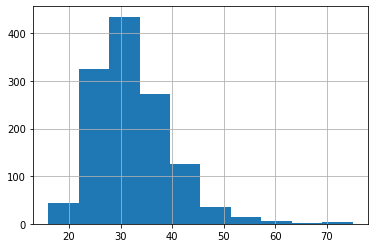

In [83]:
#looks like a realistic plot of age-ranges for working-people. that's good.
data['age'].hist()

In [84]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
db-dtypes==1.0.4
debugpy==1.0.